# Laboration maskininlärning AI22

## 1.0 - Uppvärmning
recommender_test.ipynb

## 1.1 - Movielens full - EDA

In [2]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

y:\Skola\OOP\Skolarbete\AI-Erik-Johansson-OPA23\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# load in datasets
movies='data/large/movies.csv'
ratings='data/large/ratings.csv'

df_movies=pd.read_csv(movies, usecols=['movieId', 'title'], dtype={'movieId' : 'int32', 'title' : 'str'})
df_ratings=pd.read_csv(ratings, usecols=['userId', 'movieId', 'rating'], dtype={'userId':'int32', 'movieId':'int32', 'rating':'float32'})

### a)

In [4]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [5]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int32 
 1   title    86537 non-null  object
dtypes: int32(1), object(1)
memory usage: 1014.2+ KB


In [6]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0


In [8]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 387.2 MB


In [9]:
df_ratings["userId"].value_counts()[:10]

userId
189614    33332
48766      9554
207216     9178
175998     9016
76618      8919
230765     7719
184775     7535
236260     7488
233891     7372
214831     7266
Name: count, dtype: int64

### b)

In [10]:
# sort out top 10 movieIds by which ones have the most ratings
df_ratings["movieId"].value_counts()[:10]

movieId
318     122296
356     113581
296     108756
2571    107056
593     101802
260      97202
2959     86207
527      84232
480      83026
1196     80200
Name: count, dtype: int64

In [11]:
# make list with most rated movieIds
most_rated = df_ratings["movieId"].value_counts()[:10].index.to_list()
most_rated

[318, 356, 296, 2571, 593, 260, 2959, 527, 480, 1196]

In [12]:
# Match movieId to title in movie dataframe
print("Top 10 movies by number of ratings:")
for m in most_rated:
    print(df_movies[df_movies["movieId"] == m]["title"].values[0])

Top 10 movies by number of ratings:
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Pulp Fiction (1994)
Matrix, The (1999)
Silence of the Lambs, The (1991)
Star Wars: Episode IV - A New Hope (1977)
Fight Club (1999)
Schindler's List (1993)
Jurassic Park (1993)
Star Wars: Episode V - The Empire Strikes Back (1980)


### c)

In [54]:
print("Average rating for top 10 most rated movies:")
for m in most_rated:
    # calculate mean value of ratings for each top 10 rated movie
    print(df_movies[df_movies["movieId"] == m]["title"].values[0],"Average rating: ", round(df_ratings[df_ratings["movieId"] == m]["rating"].mean(), 2))

Average rating for top 10 most rated movies:
Shawshank Redemption, The (1994) Average rating:  4.42
Forrest Gump (1994) Average rating:  4.07
Pulp Fiction (1994) Average rating:  4.19
Matrix, The (1999) Average rating:  4.16
Silence of the Lambs, The (1991) Average rating:  4.15
Star Wars: Episode IV - A New Hope (1977) Average rating:  4.09
Fight Club (1999) Average rating:  4.24
Schindler's List (1993) Average rating:  4.24
Jurassic Park (1993) Average rating:  3.69
Star Wars: Episode V - The Empire Strikes Back (1980) Average rating:  4.12


### d)

In [65]:
# Checked which years were the earliest and latest to appear by initally using (1800, 2025) -> 1874, 2023(exclusive)
years = range(1874, 2024)
# Use parenthesis '()' to avoid movies with a year in the actual title
films_per_year = [df_movies[df_movies["title"].str.contains(f"({y})", regex=False)]["movieId"].count() for y in years]
films_per_year[:5]

[1, 0, 0, 0, 2]

In [15]:
df_movies[df_movies["title"].str.contains(f"({1900})", regex=False)][:5]

,movieId,title
23423,117909,The Kiss (1900)
37918,152908,Panorama of Eiffel Tower (1900)
37919,152910,Eiffel Tower from Trocadero Palace (1900)
37920,152912,Palace of Electricity (1900)
37921,152914,Champs de Mars (1900)


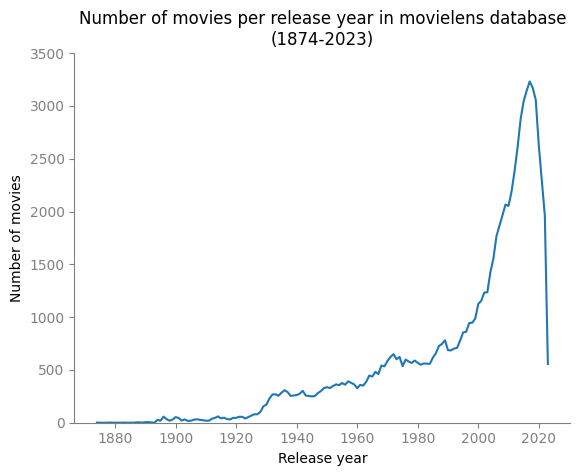

In [16]:
import seaborn as sns

ax = sns.lineplot(x=years, y=films_per_year)
ax.set(
    ylabel="Number of movies",
    xlabel="Release year",
    title="Number of movies per release year in movielens database\n(1874-2023)",
    ylim=(0, 3500),
)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(colors="gray")

### e)

In [17]:
# make lists with movieIds and number of ratings
rated_movieIds = df_ratings["movieId"].value_counts().index.to_numpy()
number_ratings = df_ratings["movieId"].value_counts().to_numpy()

# make dataframe out of lists
df_ratings_per_movie = pd.DataFrame({"movieId": rated_movieIds, "ratings": number_ratings})
df_ratings_per_movie.head()

,movieId,ratings
0,318,122296
1,356,113581
2,296,108756
3,2571,107056
4,593,101802


In [18]:
# sort dataframe by movieId
df_ratings_per_movie = df_ratings_per_movie.sort_values("movieId", ignore_index=True)
df_ratings_per_movie.head(10)

,movieId,ratings
0,1,76813
1,2,30209
2,3,15820
3,4,3028
4,5,15801
5,6,31850
6,7,15596
7,8,1584
8,9,4563
9,10,34942


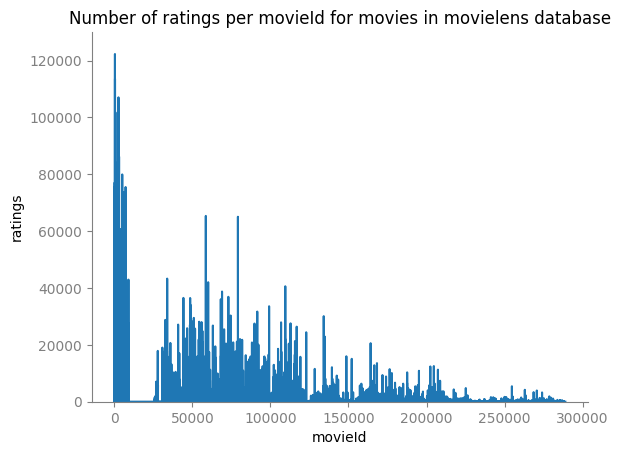

In [66]:
# barplot did not work, maybe too many values?
ax = sns.lineplot(df_ratings_per_movie, x="movieId", y="ratings")
ax.set(
    title="Number of ratings per movieId for movies in movielens database",
    ylim=(0, 130000),
)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(colors="gray")

### f)

In [20]:
# lists with titles and average ratings for top 10 most rated movies
title = [df_movies[df_movies["movieId"] == m]["title"].values[0] for m in most_rated]
avg_rating = [round(df_ratings[df_ratings["movieId"] == m]["rating"].mean(), 2) for m in most_rated]

title, avg_rating

(['Shawshank Redemption, The (1994)',
  'Forrest Gump (1994)',
  'Pulp Fiction (1994)',
  'Matrix, The (1999)',
  'Silence of the Lambs, The (1991)',
  'Star Wars: Episode IV - A New Hope (1977)',
  'Fight Club (1999)',
  "Schindler's List (1993)",
  'Jurassic Park (1993)',
  'Star Wars: Episode V - The Empire Strikes Back (1980)'],
 [4.42, 4.07, 4.19, 4.16, 4.15, 4.09, 4.24, 4.24, 3.69, 4.12])

C:\Users\Erik\AppData\Local\Temp\ipykernel_18932\915615419.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(title, rotation=90)


[Text(0, 0, 'Shawshank Redemption, The (1994)'),
 Text(1, 0, 'Forrest Gump (1994)'),
 Text(2, 0, 'Pulp Fiction (1994)'),
 Text(3, 0, 'Matrix, The (1999)'),
 Text(4, 0, 'Silence of the Lambs, The (1991)'),
 Text(5, 0, 'Star Wars: Episode IV - A New Hope (1977)'),
 Text(6, 0, 'Fight Club (1999)'),
 Text(7, 0, "Schindler's List (1993)"),
 Text(8, 0, 'Jurassic Park (1993)'),
 Text(9, 0, 'Star Wars: Episode V - The Empire Strikes Back (1980)')]

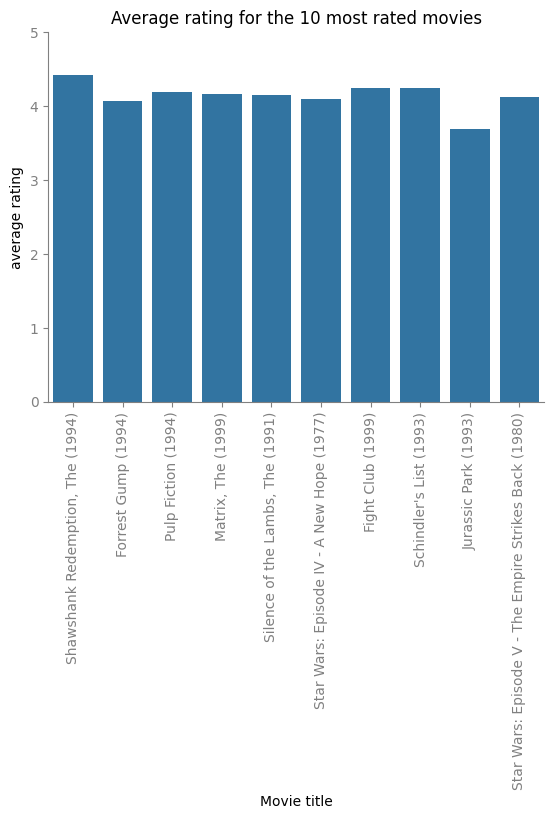

In [21]:
ax = sns.barplot(x=title, y=avg_rating)
ax.set(
    ylabel="average rating",
    xlabel="Movie title",
    title="Average rating for the 10 most rated movies",
    ylim=(0, 5)
)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(colors="gray")
ax.set_xticklabels(title, rotation=90)

## 1.2 Skapa gles matris

Jag bestämde mig för att det verkade vettigt att sortera bort filmer som hade färre ratings då dessa 

In [78]:
# suggested sorting by treshold of value counts from https://stackoverflow.com/questions/67006008/pandas-how-to-get-the-value-counts-above-a-threshold
# a treshold of at least 2000 ratings seemed to still include a solid amount of movies
df_ratings_adjusted = df_ratings[df_ratings.groupby("movieId")["movieId"].transform('size')>1000]
df_ratings_adjusted["movieId"].unique().shape
df_ratings_adjusted

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0
...,...,...,...
33832157,330975,8340,2.0
33832158,330975,8493,2.5
33832159,330975,8622,4.0
33832160,330975,8665,3.0


In [79]:
df_ratings_adjusted[df_ratings_adjusted.groupby("userId")["userId"].transform('size')>100]

,userId,movieId,rating
304,7,1,4.0
305,7,3,3.0
306,7,11,5.0
307,7,21,2.0
308,7,25,3.0
...,...,...,...
33832157,330975,8340,2.0
33832158,330975,8493,2.5
33832159,330975,8622,4.0
33832160,330975,8665,3.0


In [24]:
df_ratings_adjusted["movieId"].unique()

array([   1,  110,  158, ..., 2303, 3783, 1975])

In [25]:
# https://saturncloud.io/blog/how-to-select-rows-from-a-dataframe-based-on-list-values-in-a-column-in-pandas/

mask = df_movies["movieId"].isin(df_ratings_adjusted["movieId"].unique())

df_movies_adjusted = df_movies[mask].reset_index(drop=True)
df_movies_adjusted["movieId"][1335]

3201

In [26]:
df_movies_adjusted = df_movies[mask].reset_index(drop=True)
df_movies_adjusted

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
2953,263007,Spider-Man: No Way Home (2021)
2954,263407,Don't Look Up (2021)
2955,268642,The Batman (2022)
2956,270698,Everything Everywhere All at Once (2022)


In [27]:
movies_users=df_ratings_adjusted.pivot(index='movieId', columns='userId', values='rating').fillna(0)

In [28]:
movies_users

userId,1,2,3,4,5,6,7,8,9,10,...,330966,330967,330968,330969,330970,330971,330972,330973,330974,330975
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,...,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.5
2,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
mat_movies_users=csr_matrix(movies_users.values)

In [30]:
df_movies_adjusted

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
2953,263007,Spider-Man: No Way Home (2021)
2954,263407,Don't Look Up (2021)
2955,268642,The Batman (2022)
2956,270698,Everything Everywhere All at Once (2022)


In [31]:
movies_users.iloc[2778]

userId
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
         ... 
330971    0.0
330972    0.0
330973    0.0
330974    0.0
330975    0.0
Name: 125916, Length: 329736, dtype: float32

In [32]:
mat_movies_users[1558], df_movies_adjusted.iloc[1558]

(<1x329736 sparse matrix of type '<class 'numpy.float32'>'
 	with 4883 stored elements in Compressed Sparse Row format>,
 movieId                                 4008
 title      Born on the Fourth of July (1989)
 Name: 1558, dtype: object)

In [33]:
model_knn = NearestNeighbors(metric="minkowski", algorithm="brute", n_neighbors=20)

In [34]:
mat_movies_users[2957].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
idx=process.extractOne("Goofy Movie, A (1995)", df_movies_adjusted["title"], score_cutoff=10)[2]
df_movies_adjusted["title"][idx], idx

('Goofy Movie, A (1995)', 141)

In [36]:
df_movies_adjusted.iloc[2778]

movieId                         125916
title      Fifty Shades of Grey (2015)
Name: 2778, dtype: object

In [49]:
def recommender(idx, data, model, n_recommendations):
    model.fit(data)
    # idx = process.extractOne(movie_name, df_movies_adjusted["title"])[2]
    print("Movie Selected: ", df_movies_adjusted["title"][idx], "Index: ", idx)
    print(
        "--------------------------------\nSearching for recommendations...\n--------------------------------"
    )
    distances, indices = model.kneighbors(data[idx], n_neighbors=n_recommendations)
    print(f"10 movies most similar to {df_movies_adjusted['title'][idx]} according to user reviews:")
    for i, d in zip(indices, distances):
        for index, distance in zip(i, d):
            if index != idx:
                print(
                    f"{index}: {df_movies_adjusted['title'][index]} {round(distance)}"
                )


# recommender("Doom (2005)", mat_movies_users, model_knn, 10)

In [51]:
def choose_movie():
    user_input = input("Please enter the name of a movie:")
    choices = process.extract(user_input, df_movies_adjusted["title"], limit=5)
    print(f"Top 5 results for query: '{user_input}'")
    for c, i in zip(choices, range(1, 6)):
        print(i, c[0])
    user_input = input("Choose movie (1-5): ")
    return choices[int(user_input)-1][2]

In [52]:
movie_pick = choose_movie()
recommender(movie_pick , mat_movies_users, model_knn, 10)

Top 5 results for query: 'iron man'
1 Iron Man (2008)
2 Iron Man 2 (2010)
3 Iron Man 3 (2013)
4 Dead Man Walking (1995)
5 Lawnmower Man 2: Beyond Cyberspace (1996)
Movie Selected:  Iron Man (2008) Index:  2329
--------------------------------
Searching for recommendations...
--------------------------------
10 movies most similar Iron Man (2008) by user reviews
2470: Iron Man 2 (2010) 624
2569: Avengers, The (2012) 626
2650: Iron Man 3 (2013) 658
2405: Star Trek (2009) 658
2711: Captain America: The Winter Soldier (2014) 667
2561: Captain America: The First Avenger (2011) 667
2552: X-Men: First Class (2011) 673
2541: Thor (2011) 674
2452: Sherlock Holmes (2009) 674


In [40]:
df_movies_adjusted["title"][test]

'Rocky III (1982)'